In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from ipywidgets import widgets
import seaborn as sns
from scipy.signal import find_peaks
from time import time

# Limpieza de datos

In [2]:
dfi = pd.read_excel("Consumo horario Zonas de carga de la GCROC 2015-2019.xlsx", sheet_name="datos")
dfi.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,consumo de energía de la zona de carga (MWh),Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29
0,NaT,día de la semana,fecha,hora,ZCCI84BA14,ZCCI72BA72,ZCCI47BA64,ZCCI52BA20,ZCCI12CN54,ZCCI48CN27,...,ZCCI94JN17,ZCCI47JN87,ZCCI99JN69,ZCCI49JN14,ZCCI65JN47,ZCCI38JN61,ZCCI14QS65,ZCCI79QS2,ZCCI67QS47,ZCCI18CO76
1,2015-08-20,Jueves,2015-08-20 00:00:00,1,552.609,490.27,357.488,NaN,402.587,94.7682,...,282.895,855.283,NaN,NaN,261.085,71.5379,NaN,402.58,283.748,NaN
2,2015-08-20,NaN,NaN,2,546.262,468.488,334.402,NaN,387.418,94.0371,...,285.979,828.104,NaN,NaN,247.134,68.3344,NaN,391.484,276.328,NaN
3,2015-08-20,NaN,NaN,3,533.782,451.496,323.227,NaN,391.746,95.0278,...,289.796,821.102,NaN,NaN,237.034,64.516,NaN,381.678,273.986,NaN
4,2015-08-20,NaN,NaN,4,496.88,435.796,318.112,NaN,389.48,95.0814,...,291.609,814.015,NaN,NaN,229.384,62.7311,NaN,373.947,267.397,NaN


##### Remoción de primer encabezado y cambio de nombres en segundo encabezado

In [3]:
def lim_header(dfi):
    dfi.columns = dfi.iloc[0]
    dfi = dfi.drop(index=0)
    dfi.rename(columns = {"día de la semana" : "día_semana"}, inplace=True )
    dfi.rename(columns = {pd.NaT : "fechas"}, inplace = True)
    return dfi

##### Relleno día semana y fecha 

In [4]:
def lim_relleno():
    df = lim_header(dfi)
    dia_sem = df["día_semana"].tolist()
    fech = df["fecha"].tolist()
    hor = df["hora"].tolist()
    indx = 0
    for h in hor:
        if h == 1:
            fecha = fech[indx]
            diaa = dia_sem[indx]
            indx += 1
        elif h != 1:
            fech[indx] = fecha
            dia_sem[indx] = diaa
            indx += 1
    df["fecha"] = fech
    df["día_semana"] = dia_sem
    return df

#### Remplazo de valores no numéricos

In [5]:
def lim_Nnum():
    df = lim_relleno()
    df['year'] = pd.DatetimeIndex(df["fechas"]).year
    df['month'] = pd.DatetimeIndex(df["fechas"]).month
    df['day'] = pd.DatetimeIndex(df["fechas"]).day

    df = df.replace(["Lunes", "Martes", "Miercoles", "Jueves", "Viernes", "Sabado", "Domingo"], [0, 1, 2, 3, 4, 5, 6])
    df = df.replace(["Miércoles", "Sábado"],[2,5])

    df = df.drop(["fecha","fechas"], axis=1)
    df = df.dropna()
    
    return df

#### Cambio de nombre a zonas de carga

In [6]:
def lim_nomzon():
    df = lim_Nnum()
    zonas = df.columns
    elim = ["día_semana", "hora", "day", "year", "month"]
    zonas = zonas.drop(elim)
    son = ["zona_{}".format(i+1) for i in range(len(zonas))]
    listDic={}
    for zona, so in zip(zonas, son):
        listDic[zona]=so
    df.rename(columns = listDic, inplace=True )
    return df

In [7]:
df = lim_nomzon()
df.head()

,día_semana,hora,zona_1,zona_2,zona_3,zona_4,zona_5,zona_6,zona_7,zona_8,...,zona_20,zona_21,zona_22,zona_23,zona_24,zona_25,zona_26,year,month,day
2473,1,1,586.355954,440.413395,390.165749,92.227128,431.128498,137.563541,60.004246,569.569445,...,50.751099,284.093558,84.253804,35.907851,573.658374,232.075271,26.129796,2015,12,1
2474,1,2,534.674964,436.788257,354.979734,89.055159,422.386585,135.081111,60.753357,582.170888,...,64.692998,269.313174,86.163512,36.665166,518.169466,231.872994,27.073641,2015,12,1
2475,1,3,586.773471,410.820258,329.388087,88.308842,389.575364,126.479479,53.946456,571.150180,...,61.499443,260.163608,85.744744,33.292836,487.563347,210.873154,31.921941,2015,12,1
2476,1,4,553.468104,394.362273,324.136570,93.767899,368.112707,120.249723,47.278441,551.203493,...,58.065259,240.661857,82.420562,29.276688,468.104578,194.173398,27.477886,2015,12,1
2477,1,5,445.710449,392.564709,328.280212,101.873666,356.035860,116.066548,43.860122,543.828653,...,58.405893,237.813743,82.013899,26.761496,462.162629,184.676695,33.143631,2015,12,1


# Creación de variables "Dummies"

#### Adición de días festivos con penalización

In [8]:
def dum_fest(df):
    cata = []; fes = pd.read_csv("festivos.csv")
    for j in range(len(fes.index)):
            festiveDay = df.loc[(df.year==fes["Year"][j]) & (df.month==fes["Month"][j]) & (df.day==fes["Day"][j])].index.values.tolist()
            cata = cata + festiveDay

    df['fest'] = np.nan; df.fest = df.fest.fillna(pd.Series(-1, index=cata))
    df.fest = df.fest.fillna(0)
    df.fest.unique()
    return df

#### Variables "Dummies" día de la semana

In [9]:
# lunes   martes-miercoles-jueves   viernes   sabado   domingo
def dum_dia(df):
    df.día_semana=df.día_semana.apply(lambda x: 1 if x==1 else (2 if x in [2,3,4] else (3 if x==5 else (4 if x==6 else 0))))
    df = pd.get_dummies(df, prefix=['d_sm'], columns=['día_semana'])
    df = df.drop("d_sm_0", axis = 1)
    return df

In [10]:
# # lunes  martes  miercoles  jueves  viernes  sabado  domingo
# def dum_dia(df):
#     df.día_semana=df.día_semana.apply(lambda x: 1 if x==1 else (2 if x==2 else (3 if x==3 else (4 if x==4 else (5 if x==5 else (6 if x==6 else 0))))))
#     df = pd.get_dummies(df, prefix=['d_sm'], columns=['día_semana'])
#     df = df.drop("d_sm_0", axis = 1)
#     return df

##### "Dummies" mensuales

In [11]:
def dum_mensual(df):
    # Enero, Febrero, Marzo, Abril, Mayo, Junio, Julio, Agosto, Septiembre, Octubre, Diciembre
    df = pd.get_dummies(df, prefix=['mm'], columns=['month'])
    df = df.drop("mm_12", axis = 1)
    return df

#### "Dummies" de temporada

In [12]:
def dum_seas(df):
    df['seas'] = np.nan
    pr = df.query('day == 21 and month ==3').index
    vr = df.query('day == 21 and month == 6').index
    ot = df.query('day == 21 and month == 9').index
    inv= df.query('day == 21 and month == 12').index

    df.seas = df.seas.fillna(pd.Series(0, index=pr))
    df.seas = df.seas.fillna(pd.Series(1, index=vr))
    df.seas = df.seas.fillna(pd.Series(2, index=ot))
    df.seas = df.seas.fillna(pd.Series(3, index=inv))

    df.seas = df.seas.fillna(method= 'ffill')
    df.seas = df.seas.fillna(method= 'bfill')

    df = pd.get_dummies(df, prefix=['s_s'], columns=['seas'])
    df = df.drop("s_s_3.0", axis = 1)

    return df

----------------------------------------------------------------------

#### llamada funciones dummies

In [13]:
def dumm(df):
    df = dum_fest(df)
    df = dum_dia(df)
    df = dum_seas(df)
    df = dum_mensual(df)
    return df

In [14]:
df = dumm(df)
df.head()

,hora,zona_1,zona_2,zona_3,zona_4,zona_5,zona_6,zona_7,zona_8,zona_9,...,mm_2,mm_3,mm_4,mm_5,mm_6,mm_7,mm_8,mm_9,mm_10,mm_11
2473,1,586.355954,440.413395,390.165749,92.227128,431.128498,137.563541,60.004246,569.569445,288.090105,...,0,0,0,0,0,0,0,0,0,0
2474,2,534.674964,436.788257,354.979734,89.055159,422.386585,135.081111,60.753357,582.170888,279.116514,...,0,0,0,0,0,0,0,0,0,0
2475,3,586.773471,410.820258,329.388087,88.308842,389.575364,126.479479,53.946456,571.150180,267.361890,...,0,0,0,0,0,0,0,0,0,0
2476,4,553.468104,394.362273,324.136570,93.767899,368.112707,120.249723,47.278441,551.203493,258.277029,...,0,0,0,0,0,0,0,0,0,0
2477,5,445.710449,392.564709,328.280212,101.873666,356.035860,116.066548,43.860122,543.828653,252.272364,...,0,0,0,0,0,0,0,0,0,0


In [15]:
df.columns

Index(['hora', 'zona_1', 'zona_2', 'zona_3', 'zona_4', 'zona_5', 'zona_6',
       'zona_7', 'zona_8', 'zona_9', 'zona_10', 'zona_11', 'zona_12',
       'zona_13', 'zona_14', 'zona_15', 'zona_16', 'zona_17', 'zona_18',
       'zona_19', 'zona_20', 'zona_21', 'zona_22', 'zona_23', 'zona_24',
       'zona_25', 'zona_26', 'year', 'day', 'fest', 'd_sm_1', 'd_sm_2',
       'd_sm_3', 'd_sm_4', 's_s_0.0', 's_s_1.0', 's_s_2.0', 'mm_1', 'mm_2',
       'mm_3', 'mm_4', 'mm_5', 'mm_6', 'mm_7', 'mm_8', 'mm_9', 'mm_10',
       'mm_11'],
      dtype='object')

#### Función para lista con nombre de zonas

In [16]:
def sonas():
    zonas = df.columns; son = ["zona_{}".format(i+1) for i in range(26)]
    return son
son = sonas()

----------------------------------------------------------------------

# Funciones para regresíon

- Función para obtencion de serie con datos $hora:i$ y $zona:j$

In [17]:
def get_zon_hor(h,z):
    hora_n = df.query('hora == {}'.format(h))
    zon_n = hora_n['{}'.format(z)]
    return zon_n.values

- Función para obtención de Dummies

In [18]:
def get_dums(h):
    dem = ['hora', 'year', 'month']
    zro = son #+ dem
    sin_zonas = df.query(f'hora == {h}')
    sin_zonas=sin_zonas.reset_index()
    sin_zonas = sin_zonas.drop(zro,  axis=1)
    sin_zonas = sin_zonas.drop(['index', 'hora'], axis=1)
    sin_zonas["ones"] = 1
    return  sin_zonas

- Función de Kronecker solo con dummies

In [19]:
def kron1(h, z):
    #Definicion de valores
    dm1 = get_dums(h); y = get_zon_hor(h, z)
    kron = pd.DataFrame()
    t = pd.DataFrame(np.arange(0, len(y)).tolist()); t.columns = ["te"]
    error = pd.DataFrame()
    
    #Primer kronecker
    kron = dm1.multiply(t["te"] , axis="index")
    kron.columns = [f'{i}_t' for i in dm1.columns]
    kron1 = pd.concat([kron, get_dums(h)], sort = False, axis=1)
    kron1 = kron1.drop("year_t", axis = 1)
    
    return kron1

In [20]:
kron1(1, "zona_1").head()

,day_t,fest_t,d_sm_1_t,d_sm_2_t,d_sm_3_t,d_sm_4_t,s_s_0.0_t,s_s_1.0_t,s_s_2.0_t,mm_1_t,...,mm_3,mm_4,mm_5,mm_6,mm_7,mm_8,mm_9,mm_10,mm_11,ones
0,0,0.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,2,0.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,6,0.0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,12,0.0,0,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,20,0.0,0,0,4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [21]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

- Función de MAPE general

In [22]:
def MAPE(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    ma = np.mean(np.abs((y_true - y_pred) / y_true) * 100)
    return ma

- Función de MAPE hora por hora

In [23]:
def MAPE_hor(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    ma = np.abs((y_true - y_pred) / y_true) * 100
    return ma

In [24]:
def plot_mpdummies(h, z):
    y = get_zon_hor(h, z)
    kron = kron1(h, z)
    
    #Regresion
    reg = LinearRegression(n_jobs = -1, fit_intercept=False).fit(kron, y)
    y_pred = reg.predict(kron)
    
    #mapes
    map3 = MAPE_hor(y, y_pred)
    
    #grafico 1
    plt.figure(figsize=(13,13))
    plt.plot(y, label='real')
    plt.plot(y_pred, label='prediccíon')
    plt.plot(map3, label="MAPE")
    plt.xlabel("Día")
    plt.ylabel("Consumo Mwh")
    plt.title("Ajuste de modelo vs consumo real")
    plt.grid(True)
    plt.legend()
    plt.show()
    
    #grafico 2
    plt.figure(figsize=(14,12))
    plt.plot(map3, label="MAPE")
    plt.grid(True)
    plt.xlabel("día")
    plt.ylabel("Mape")
    plt.legend(loc="best")
    plt.title("MAPE de model de dummies")
    plt.show()
    return 

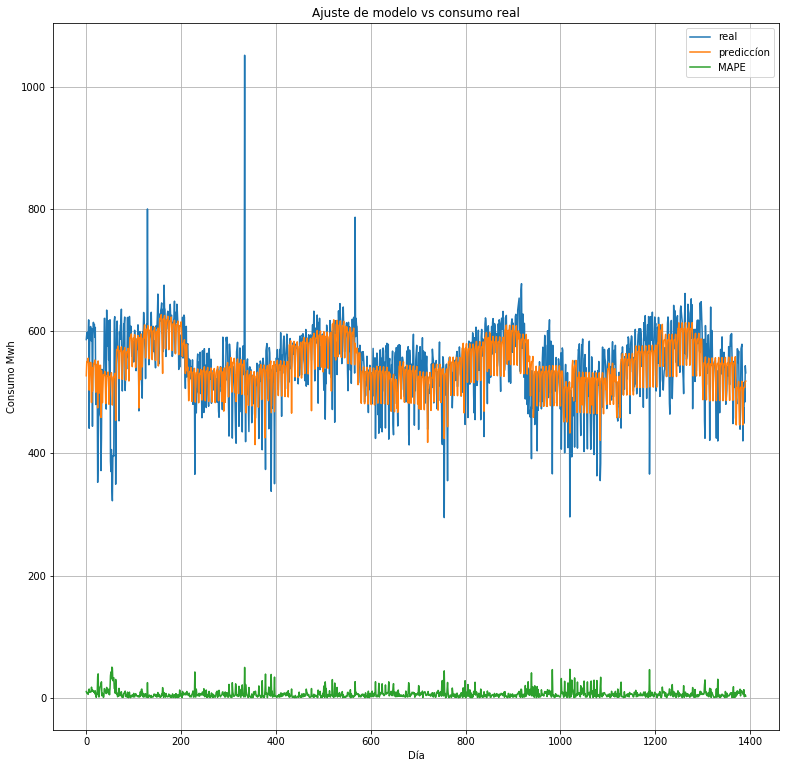

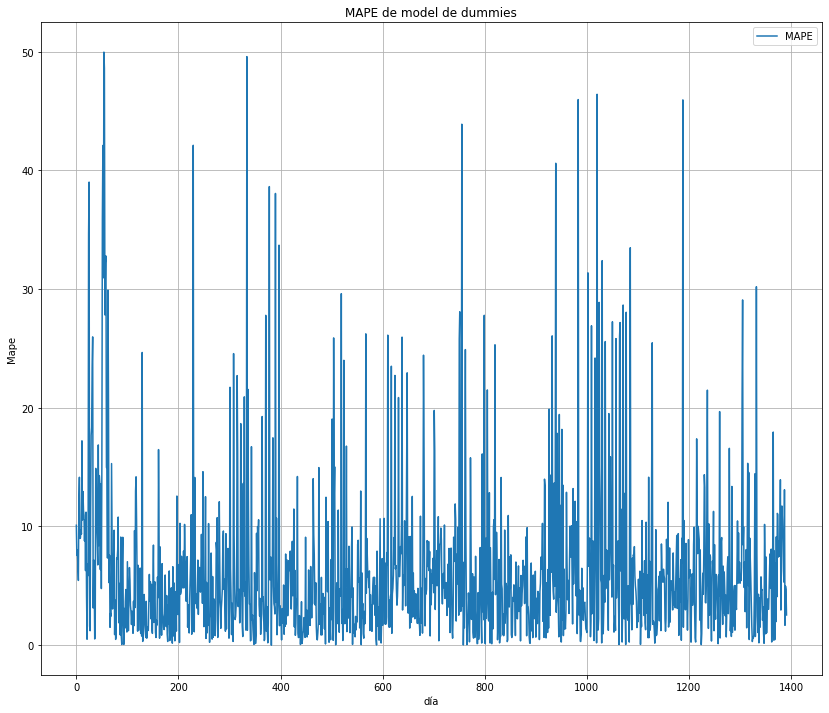

In [25]:
plot_mpdummies(1, "zona_1")

- Función de regresion_1 para obtener error y calcular picos

In [26]:
from  scipy.signal import periodogram

In [27]:
def reg1_mpaltura(h, z):
    y = get_zon_hor(h, z)
    kron = kron1(h, z)
    #Regresion
    reg = LinearRegression(n_jobs = -1, fit_intercept=False).fit(kron, y)
    y_pred = reg.predict(kron)
    
    #mapes
    map3 = MAPE_hor(y, y_pred)

    
    #Para encontrar picos
    mp50, _ = find_peaks(map3, height=50)
    mp40, _ = find_peaks(map3, height=40)
    mp30, _ = find_peaks(map3, height=30)
    mp20, _ = find_peaks(map3, height=20)
    mp10, _ = find_peaks(map3, height=10)
    
    # Restar picos de otras alturas
    mp10 = np.setdiff1d(mp10, mp20)
    mp20 = np.setdiff1d(mp20, mp30)
    mp30 = np.setdiff1d(mp30, mp40)
    mp40 = np.setdiff1d(mp40, mp50)
    
    
    kron["dif"] = np.nan
    kron.dif = kron.dif.fillna(pd.Series(-1, index=mp10))
    kron.dif = kron.dif.fillna(pd.Series(-2, index=mp20))
    kron.dif = kron.dif.fillna(pd.Series(-3, index=mp30))
    kron.dif = kron.dif.fillna(pd.Series(-4, index=mp40))
    kron.dif = kron.dif.fillna(pd.Series(-5, index=mp50))
    kron.dif = kron.dif.replace(np.nan, 0)    
    
    #Error
    error = (y-y_pred)
    f, asd = periodogram(error, fs=1)
    peaks, _ = find_peaks(asd, height = 25000)
    return kron, peaks

- Función para obtención de coeficientes de senos y cosenos

In [28]:
def get_sc_coef(h, z):
    X = pd.DataFrame()
    t = np.arange(len(df[df["hora"]==h]))
    _, p = reg1_mpaltura(h, z)
    for i  in p:
        X["{}_sen".format(i)] = np.sin((t*2*np.pi)/i)
        X["{}_cos".format(i)] = np.cos((t*2*np.pi)/i)
    return X

- Funcion de multiplicación de filas por Kronecker + addición de variables Dummies y coeficientes

In [29]:
def kron_conv(h, z):
    #Definicion de valores
    y = get_zon_hor(h, z)
    t = pd.DataFrame(np.arange(1, len(y)+1).tolist()); t.columns = ["te"]

    
    #Segundo kronecker
    dm1, _ = reg1_mpaltura(h, z); dm2 = get_sc_coef(h, z)
    dm1 = dm1.drop("dif", axis = 1)
    d3 = pd.DataFrame(); kron = pd.DataFrame()
    for i in dm2.columns:
        d3 = dm1.multiply(dm2[f"{i}"], axis="index")
        d3.columns = [f"{j}_{i}" for j in dm1.columns]
        kron = pd.concat([kron, d3], axis = 1)
    
    X = kron.reset_index()
    X2 = pd.concat([X, get_dums(h), get_sc_coef(h, z)], sort = False, axis=1)
    X2 = X2.drop('index', axis = 1)
    return X2

## Regresión 

In [30]:
def get_train_split_sick(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.015, shuffle = False) #0.015
    return X_train, X_test, y_train, y_test

In [31]:
def get_train_split_xgb(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = False)
    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size =  float(format(20/len(y_test), '.3f')), shuffle = False) #0.06
    return X_train, X_test, X_val, y_train, y_test, y_val 

In [32]:
from statsmodels.tsa.ar_model import AR
from xgboost import XGBRegressor 

In [33]:
def reg(h, z):
    import warnings
    warnings.filterwarnings("ignore", category=FutureWarning)
    
    y = pd.Series(get_zon_hor(h, z))
    X = kron_conv(h, z)
    X_tr, X_te, y_tr, y_te = get_train_split_sick(X, y)
    
    #Regressión con scikitlearn
    regress = LinearRegression(fit_intercept=True, n_jobs=-1, normalize=True).fit(X_tr, y_tr)
    y_pred = regress.predict(X_te)
    m = MAPE(y_te, y_pred)
    
    #Auto Arima
    regresar = AR(y_tr).fit()
    y_predico = regresar.predict(start=len(y_tr), end=len(y_tr) + len(y_te)-1, dynamic=False)
    m3 = MAPE(y_te, y_predico)
    
    #Regressión con XGBoost
    X_train, X_test, X_val, y_train, y_test, y_val = get_train_split_xgb(X, y)
    regress2 = XGBRegressor(objective ='reg:squarederror', n_jobs=-1, max_depth=3, learning_rate=1.5, n_estimators=5)#
    regress2.fit(X_train, y_train, eval_set=[(X,y),(X_val,y_val)], verbose=0)#, , early_stopping_rounds=50)
    y_pred2 = regress2.predict(X_test)
    m2 = MAPE(y_test, y_pred2)
    
    # Valores de Y que concuerdan con indice de y_pred y y_pred2
    ma = [m + m2 + m3]
    print("{}, hora_{}: Scikit_{:.3f} XGBoost_{:.3f} AR_{:.3f}".format(z, h, m, m2, m3))
    
    return y_te.index, y_test.index, y_pred, y_pred2, y_predico, ma;

Corrida funcíon de regresión

In [34]:
hora_ = 1; zona_ = 'zona_1'

In [38]:
beg = time()
y = pd.Series(get_zon_hor(hora_ , zona_))
x, x2, y_pred, y_pred2, y_pred3, ms = reg(hora_, zona_)

end = time()
print('\n tiempo de corrida:', end - beg)

zona_1, hora_1: Scikit_721.812 XGBoost_8.276 AR_7.029

 tiempo de corrida: 0.876624345779419


Corrida para todas las zonas en todos los horarios

In [ ]:
beg = time()
for hora_ in range(1, 25):
    for zona_ in son:
        reg(hora_, zona_)
end = time()
print('\n tiempo de corrida:', end - beg)

----------------------------------------------------------------------

## Gráficos 

#### Grafico de autocorrelación

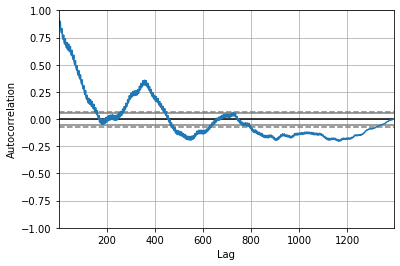

In [83]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(y);

##### Y vs Y_pred

Matplotlib

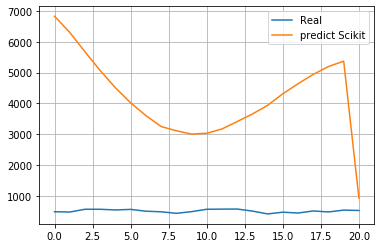

In [113]:
# plt.figure(figsize=(13,13))
plt.plot(y[x].values, label="Real")
plt.plot(y_pred, label="predict Scikit")
plt.grid(True)
plt.legend()

plt.show()

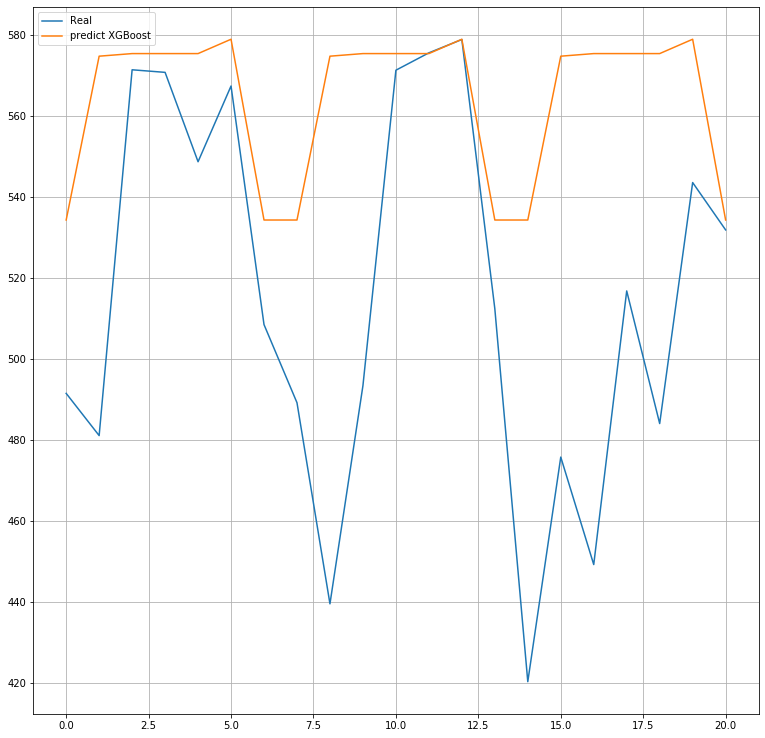

In [54]:
plt.figure(figsize=(13,13))
plt.plot(y[x].values, label="Real")
plt.plot(y_pred2, label="predict XGBoost")

plt.grid(True)
plt.legend()

plt.show()

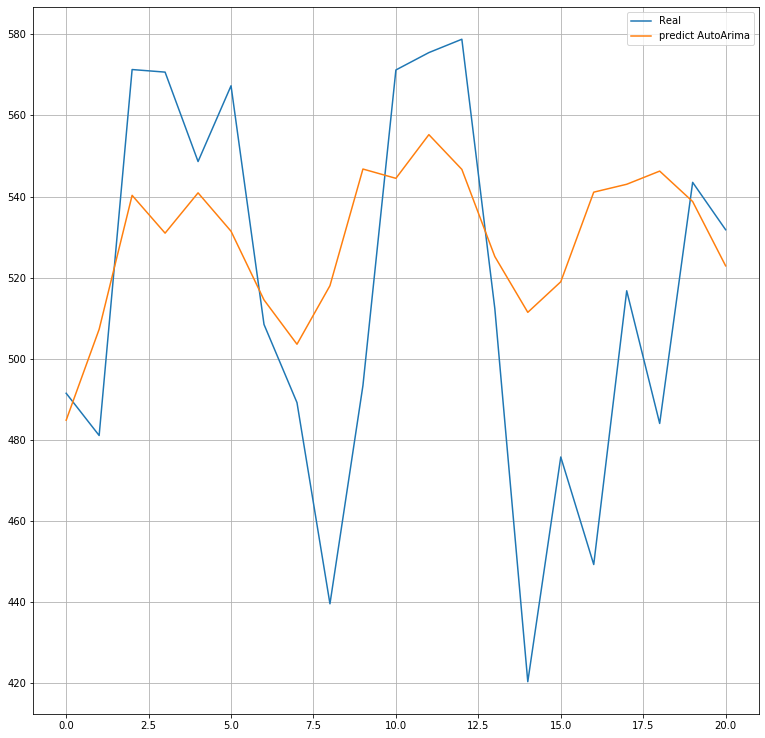

In [112]:
plt.figure(figsize=(13,13))
plt.plot(y[x2].values, label="Real")
plt.plot(y_pred3.values, label="predict AutoArima")
plt.grid(True)
plt.legend()

plt.show()